# An Introduction to the Amazon Fraud Detector API  
#### Supervised fraud detection  
-------
- [Introduction](#Introduction)
- [Setup](#Setup)
- [Plan](#Plan)


## Introduction
-------

Amazon Fraud Detector is a fully managed service that makes it easy to identify potentially fraudulent online activities such as online payment fraud and the creation of fake accounts. Fraud Detector capitalizes on the latest advances in machine learning (ML) and 20 years of fraud detection expertise from AWS and Amazon.com to automatically identify potentially fraudulent activity so you can catch more fraud faster. 

In this notebook, we'll use the Amazon Fraud Detector API to create a dector, train a model, and author rules. Next we'll apply the detector on sample data to identify potentially fraudlent envents. After running this notebook you should be able to: 

- Create a Detector  
- Train a Machine Learning(ML) Model   
- Author Rules to identify potiental fraud based on the model's score 
- Apply the Detector's "predict" function, to generate a model score and rule outcomes on data  

If you would like to know more, please check out the [Fraud Detector's Documentation](https://docs.aws.amazon.com/frauddetector/). 


## Setup
------
First setup your AWS credentials so that Fraud Detector can store and access training data and supporting detector artifacts 


### Setting up AWS Credentials & Permissions

https://docs.aws.amazon.com/frauddetector/latest/ug/set-up.html

see: Sample Fraud Detector - Create IAM Role  

To use Amazon Fraud Detector, you have to set up permissions that allow access to the Amazon Fraud Detector console and API operations. You also have to allow Amazon Fraud Detector to perform tasks on your 
behalf and to access resources that you own.

We recommend creating an AWS Identify and Access Management (IAM) user with access restricted to Amazon Fraud Detector operations and required permissions. You can add other permissions as needed.

The following policies provide the required permission to use Amazon Fraud Detector:

- *AmazonFraudDetectorFullAccessPolicy*  
    Allows you to perform the following actions:  
        - Access all Amazon Fraud Detector resources  
        - List and describe all model endpoints in Amazon SageMaker  
        - List all IAM roles in the account  
        - List all Amazon S3 buckets  
        - Allow IAM Pass Role to pass a role to Amazon Fraud Detector  

- *AmazonS3FullAccess*  
    Allows full access to Amazon S3. This is required to upload training files to S3.  




## Plan
### Plan a Fraud Detector
------
A *Detector* contains the model(s) and rule(s) detection logic for a particular type of fraud that you want to detect. We'll use the following 5 step process to plan a Fraud Detector: 

1. Define your Detector   
    - What is the Name of the Detector 
    - How would you describe the Detector 
    
2. Define & Train your Model   
    - What do you want to call your Model 
    - What dataset are you going to train your Model with
    - Promote your model 
    
3. Author your Rules   
    - What are your detection outcomes: Approve, Investigate, Refer 
    - For each rule you author:
        - what logic do you want to apply to get an outcome - provided logic to generate approve, investigate, decline rules 
        
4. Assemble the Detector  
    - Which Model(s) & Version 
    - Which Rule(s) & Version 
    
5. Test your Detector 
    - Interactively call predict on a single record 
    - Apply your Detector to a set of records  
    



In [1]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
# ------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import os
import sys
import time
from datetime import datetime
import json

# -- AWS stuff -- 
import boto3
import sagemaker

# -- sklearn --
from sklearn.metrics import roc_curve, roc_auc_score, auc, roc_auc_score
%matplotlib inline 

## Initialize AWS Fraud Detector Client 
------

https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/frauddetector.html 


In [2]:
# -- fraud detector client
client = boto3.client('frauddetector')
# -- suffix is appended to detector and model name for uniqueness  
sufx   = datetime.now().strftime("%Y%m%d")


### 1. Define your Detector  
-----
    - What do you want to Name the Detector? 
    - How would you describe the Detector?
    
    
<div class="alert alert-info"> 💡 <strong> Detector Name </strong>

- Detector names can contain: lowercase a-z and contain 0-9 and underscores, for example <b> your_1st_detector</b> is valid  
- If you plan on using the Prediction API notebook make note of your DETECTOR and MODEL NAME / Version
</div>

In [3]:
# -- give your detector a name, it should be lowercase and contain a-z 0-9 and underscores -- 
DETECTOR_NAME = "sample_detector_" + sufx                          
DETECTOR_DESC = "detects synthetic fraud events created:" + sufx 

In [4]:
# -- put detector, initalizes your detector -- 
response = client.put_detector(detectorId  = DETECTOR_NAME, description = DETECTOR_DESC )

## 2. Train 




### Define & Train your Model  
------
    - What do you want to Name your model?
    - How would you describe your model?
    - Do you have a iam role defined to acess the s3 bucket where your CSV file lives?
    - Map the mandatory variables and enrichment variables 
    - Kick off training 


#### 2a. Bucket, Dataset, ARN, Model Name & Description  
- You will need the following pieces of information to get started:
    - S3 bucket name   
    - S3 file URL   
    - ARN/IAM role  see: https://docs.aws.amazon.com/frauddetector/latest/ug/set-up.html  
    - Name & Describe your Model 
    
#### 2b. Load & Profile your Data 
- Eyeball the file, does it look ok?
  
#### 2c. Define Variables & Roles   
- Mandatory Varibles
    - map: event_timestamp, ip_address, and email address 
- Enrichment Variables 
    - map: user_agent, card_bin, phone etc... fields that have specific enrichments 
   
- Automatically add additional numeric / categorical fields to your model  
    - preview the fields included in your model  
    
- Specify any fields to exclude from your model  
    - specify any excluded fields  

#### 2d. Train your model  

#### 2e. Promote your model  

-----
#### 2a. Bucket, Dataset, ARN, Model Name & Description 

<div class="alert alert-info"> 💡 <strong> Buckets, ARN and Model Name </strong>

- S3_BUCKET is the name of the bucket where your file lives
- S3_FILE is the URL to your s3 file
- ARN_ROLE is the data access role "ARN" for the training data source. 

<b> Model Information:</b>  
- MODEL_NAME - must be unique and can contain lowercase a-z, 0-9 and underscores, for example <b> your_1st_model</b> is valid  
- MODEL_DESC - optional free text describing your model name.  


</div>

```
Note: To use Amazon Fraud Detector, you have to set up permissions that allow access to the Amazon Fraud
Detector console and API operations. You also have to allow Amazon Fraud Detector to perform tasks on
your behalf and to access resources that you own. We recommend creating an AWS Identify and Access Management (IAM) user with access restricted to. Amazon Fraud Detector operations and required permissions. You can add other permissions as needed. See "Create an IAM User and Assign Required Permissions" in the user's guide:
```
https://docs.aws.amazon.com/frauddetector/latest/ug/frauddetector.pdf


```python

S3_FILE    = "s3://your-s3-bucket-name/your-csv-file.csv" # -- s3 file url 
ARN_ROLE   = "arn:aws:iam::XXXXX:role/service-role/AmazonFraudDetector-DataAccessRole-XXXX" # -- The data access role ARN for the training data source. 
MODEL_NAME = "your_fraud_model_" +  sufx  # -- give your detector a name, it should be lowercase and contain a-z 0-9 and underscores 
MODEL_DESC = "model trained on: " + S3_FILE

```

In [5]:
S3_FILE    = "s3://afd-sample-bucket/detector_1/synthitic_newaccount_data_50k.csv" # -- s3 file url 
ARN_ROLE   = "arn:aws:iam::149894529802:role/service-role/AmazonFraudDetector-DataAccessRole-1575916842747" # -- The data access role ARN for the training data source. 
MODEL_NAME = "sample_model_" +  sufx  # -- give your detector a name, it should be lowercase and contain a-z 0-9 and underscores 
MODEL_DESC = "model trained on: " + S3_FILE

#### 2a. Load & Profile your Data 

<div class="alert alert-info"> 💡 <strong> Eyeball the first 10 Records </strong>

- does your data look reasonable? 
</div>

In [6]:
df = pd.read_csv(S3_FILE)
df.head(10)

,order_amt,ip_address,email_address,credit_card_bin,billing_postal,shipping_postal,event_timestamp,customer_name,billing_address,shipping_address,is_fraud
0,8036.0,192.18.59.93,synth_patrickjennings@gmail.com,42785,17740-2745,20950-6945,2019-03-31 11:21:22,Jeremy Dougherty,"4429 Ann Center\nDonnachester, GA",689 Jessica Centers Suite 969\nNorth Timothypo...,0
1,7839.0,192.88.102.55,synth_nicholas60@yahoo.com,30004,81975-4358,10975-4292,2019-06-23 02:13:27,Scott Keller,"451 Corey Hollow\nLake Vincentview, WA","6574 Wyatt Common\nLanestad, NC",0
2,3225.0,192.52.207.254,synth_chill@yahoo.com,54517,96275-0682,89722-4734,2019-04-13 23:55:51,Stacy Riggs,"2704 Laura Spurs\nEast Kathyland, NH","237 Butler Stream Suite 076\nHendersonview, WY",0
3,8109.0,198.10.49.139,synth_ericksonrandy@yahoo.com,35933,49934-1837,31347-4011,2020-01-03 18:29:06,Angela Robinson,"663 Simpson Ramp Apt. 033\nSouth Matthew, VT","189 Lynn Course\nBillyville, MD",0
4,4926.0,192.0.116.87,synth_gwade@hotmail.com,54658,88645-7360,03075-4962,2019-08-16 07:03:38,Caroline Herrera PhD,"6614 Seth Mountains Suite 667\nEast Erinland, LA","PSC 7948, Box 4183\nAPO AE",0
5,4222.0,192.175.78.0,synth_butleralyssa@hotmail.com,34278,30306-3390,80199-2193,2019-06-22 15:45:13,Diane Brown,"0489 Bryant Vista Suite 117\nWest Karen, GA",47245 White Gateway Suite 221\nRichardsonburgh...,0
6,2145.0,188.206.181.90,synth_egardner@yahoo.com,54529,25854-3936,26857-5977,2019-04-21 23:07:52,Sergio Atkins,"267 Tristan Rapid\nSanchezland, NE","22982 Elijah Fields\nBrianview, DC",0
7,7387.0,201.182.234.199,synth_fisherroberta@hotmail.com,65129,41317-6920,83665-7608,2020-01-30 18:42:41,Samantha Murphy,"714 Jamie Views\nChavezstad, VA","30904 Acevedo Pine Suite 679\nJohnsonmouth, OR",0
8,3250.0,192.31.192.73,synth_bwilson@gmail.com,35053,01587-9697,01785-2338,2020-02-24 03:04:28,Amber Acevedo,"661 Kaitlin Pines Suite 470\nSouth Thomas, NC","16206 Marissa Mount\nKarenbury, AZ",0
9,3182.0,192.87.77.15,synth_estradajoseph@gmail.com,44268,35704-6694,34724-3727,2020-02-13 21:15:33,Caroline Luna,"713 Anthony Rapid Apt. 059\nEast Hunterville, MI","00905 Knight Views Suite 746\nNew Justinfort, NY",0


#### 2b. Define Variables & Roles 
Fraud Detector models have 4 required fields: 
    - event_timestamp
    - ip_address
    - email_address
    - fraud_label
    
Enrichment fields can include things like USERAGENT, PHONE, CARD_BIN etc. see documentation 
    - user_agent
    - card_bin

<div class="alert alert-info"> 💡 <strong> Map Requried and Enrichment Fields </strong>

- Specify your FRAUD_LABEL field, this is the column name that you are atempting to predict 
- Map required(EVENT_TIMSTAMP, IP_ADDRESS, and EMAIL_ADDRESS) fields to column names, these are required  
- Map optional enrichment fields 
- List any fields to exclude from your datasource 

Note: all other numeric fields will be mapped as custom numeric fields, and character fields will be mapped to custom character fields 
</div>

```python
# -- map fraud label 
FRAUD_LABEL     = "your-fraud-label-field"

# -- map required fields dictionary
required_features = {
    "EVENT_TIMESTAMP" : "your-timestamp-field",
    "IP_ADDRESS"      : "your-ip-address-field",
    "EMAIL_ADDRESS"   : "your-email-address-field",
}
# -- map optional enrichment fields dictionary
enrichment_features = {
}

# -- list any fields you want to exlcude 
drop_fields = [ "drop-field_1" ]


required_fields = list(required_features.values()) + list(enrichment_features.values())
required_fields

```

In [7]:
# -- map fraud label 
FRAUD_LABEL     = "is_fraud"

# -- map required fields dictionary
required_features = {
    "EVENT_TIMESTAMP" : "event_timestamp",
    "IP_ADDRESS"      : "ip_address",
    "EMAIL_ADDRESS"   : "email_address",
}
# -- map optional enrichment fields dictionary
enrichment_features = {
}

# -- list any fields you want to exlcude 
drop_fields = [ ]


required_fields = list(required_features.values()) + list(enrichment_features.values())
required_fields

['event_timestamp', 'ip_address', 'email_address']

### Summary Statistics 
- This section provides a quick validation check on each field in the system

<div class="alert alert-info"> 💡 <strong> Eyeball Summary Statisitcs </strong>

- check identifies issues with nulls and nunique_pct % 
- returns a summary statisitcs and <b> excluded fields based on null and unique checks </b>
</div>

In [8]:
def summary_stats(df):
    """ Generate summary statsitics for a panda's data frame 
        
        Args:
            df (DataFrame): panda's dataframe to create summary statisitcs for.
        
        Todo: 
            - add screening & integrity checks 
            - convert EVENT_TIMESTAMP to datetime 
            - add some data profiling 
    
        Returns:
            DataFrame of summary statistics 
    """
    df = df.copy()
    rowcnt = len(df)
    df_s1  = df.agg(['count', 'nunique']).transpose().reset_index().rename(columns={"index":"_column"})
    df_s1["null"] = (rowcnt - df_s1["count"]).astype('int64')
    df_s1["not_null"] = rowcnt - df_s1["null"]
    df_s1["null_pct"] = df_s1["null"] / rowcnt
    df_s1["nunique_pct"] = df_s1['nunique']/ rowcnt
    dt = pd.DataFrame(df.dtypes).reset_index().rename(columns={"index":"_column", 0:"_dtype"})
    df_stats = pd.merge(dt, df_s1, on='_column', how='inner').round(4)
    df_stats['nunique'] = df_stats['nunique'].astype('int64')
    df_stats['count'] = df_stats['count'].astype('int64')
    
    # -- null check 
    df_stats['null_check'] =  df_stats['null_pct'].apply(lambda x: 'Pass' if x <= 0.5 else '-- exclude --')
    # -- unique check 
    df_stats['nunique_check'] =  df_stats['nunique_pct'].apply(lambda x: 'Pass' if x <= 0.8 else '-- exclude --')
    # -- target check 
    
    exclude_fields = df_stats.loc[(df_stats['null_check'] != 'Pass') | (df_stats['nunique_check'] != 'Pass') ]['_column'].to_list()
    

    print("--- summary stats ---")
    print(df_stats)
    print("\n")
    
    return df_stats, exclude_fields

df_stats, exclude_fields = summary_stats(df)

--- summary stats ---
             _column   _dtype  count  nunique  null  not_null  null_pct  nunique_pct null_check  nunique_check
0          order_amt  float64  50000     7256     0     50000       0.0       0.1451       Pass           Pass
1         ip_address   object  50000     2227     0     50000       0.0       0.0445       Pass           Pass
2      email_address   object  50000     2204     0     50000       0.0       0.0441       Pass           Pass
3    credit_card_bin    int64  50000     1892     0     50000       0.0       0.0378       Pass           Pass
4     billing_postal   object  50000     1930     0     50000       0.0       0.0386       Pass           Pass
5    shipping_postal   object  50000     2060     0     50000       0.0       0.0412       Pass           Pass
6    event_timestamp   object  50000    49959     0     50000       0.0       0.9992       Pass  -- exclude --
7      customer_name   object  50000    40210     0     50000       0.0       0.8042      

<div class="alert alert-info"> 💡 <strong> List additional Fields </strong>

- Numeric and Character Fields that are NOT IN excluded fields list above, required fields, enrichment fields, drop_fields and fraud label will be automatically added as custom numeric and character fields 
</div>

In [9]:
# --- list of numeric features ---- 
numeric_features = [ c for c in df.select_dtypes(include=['float32', "float64", "uint8", 'int64']).columns if c not in required_fields + exclude_fields + drop_fields + [FRAUD_LABEL] ]
print(numeric_features)

['order_amt', 'credit_card_bin']


In [10]:
# --- list of categorical  features ---- 
categorical_features = [ c for c in df.select_dtypes(include=['object']).columns if c not in required_fields + exclude_fields + drop_fields + [FRAUD_LABEL]]
print(categorical_features)

['billing_postal', 'shipping_postal']


<div class="alert alert-info"> 💡 <strong>Functions to Create Variables </strong>

- The following functions will  **create all the variables** used by the model 
</div>

In [11]:
# --- no changes just run this code block ---
def create_label(df, FRAUD_LABEL):
    """
    Returns a dictionary for the model labelSchema, by identifying the rare event as fraud / and common as not-fraud 
    
    Arguments:
    df          -- input dataframe 
    FRAUD_LABEL -- the name of the field that contains fraud label  
    
    Returns:
    labelSchema -- a dictionary containing labelKey & labelMapper 
    """
    label_summary = df[FRAUD_LABEL].value_counts()
    labelSchema = {'labelKey': FRAUD_LABEL,
                   "labelMapper" : { "FRAUD": [str(label_summary.idxmin())], 
                                     "LEGIT": [str(label_summary.idxmax())]}
                  }
    return labelSchema
    
# -- function to create all your variables --- 
def create_variables(required_features, enrichment_features, numeric_features, categorical_features, MODEL_NAME):
    """
    Returns a variable list of model input variables,it checks to see if variable exists,
    if not then it addes the variable to Fraud Detector 
    
    Arguments: 
    required_features    -- dictionary of required features (ip,email,timestamp)
    enrichment_features  -- dictionary of optional features, mapped to specific variable types enriched (CARD_BIN, USERAGENT)
    numeric_features     -- optional list of numeric field names 
    categorical_features -- optional list of categorical features 
    
    Returns:
    variable_list -- a list of variable dictionaries 
    
    """
    variable_list = []
    # -- first do the required fields 
    for feature in required_features.keys(): 
        variable_list.append( {'name' : required_features[feature]})
        try:
            client.get_variables(name=required_features[feature])
        except:
            print("Creating variable: " + required_features[feature])
            resp = client.create_variable(
                    name = required_features[feature],
                    dataType = 'STRING',
                    dataSource ='EVENT',
                    defaultValue = '<unknown>', 
                    description = required_features[feature],
                    variableType = feature )
    
    for feature in enrichment_features.keys(): 
        variable_list.append( {'name' : enrichment_features[feature]})
        try:
            client.get_variables(name=enrichment_features[feature])
        except:
            print("Creating variable: " + enrichment_features[feature])
            resp = client.create_variable(
                    name = enrichment_features[feature],
                    dataType = 'STRING',
                    dataSource ='EVENT',
                    defaultValue = '<unknown>', 
                    description = enrichment_features[feature],
                    variableType = feature )
                
               
    # -- check and update the numeric features 
    for feature in numeric_features: 
        variable_list.append( {'name' : feature})
        try:
            client.get_variables(name=feature)
        except:
            print("Creating variable: " + feature)
            resp = client.create_variable(
                    name = feature,
                    dataType = 'FLOAT',
                    dataSource ='EVENT',
                    defaultValue = '0.0', 
                    description = feature,
                    variableType = 'NUMERIC' )
             
    # -- check and update the categorical features 
    for feature in categorical_features: 
        variable_list.append( {'name' : feature})
        try:
            client.get_variables(name=feature)
        except:
            print("Creating variable: " + feature)
            resp = client.create_variable(
                    name = feature,
                    dataType = 'STRING',
                    dataSource ='EVENT',
                    defaultValue = '<unknown>', 
                    description = feature,
                    variableType = 'CATEGORICAL' )
    
    # -- Model Score 
    model_feature = MODEL_NAME + "_insightscore"
    # variable_list.append( {'name' : model_feature})
    try:
        client.get_variables(name=model_feature)
    except:
        print("Creating variable: " + model_feature)
        resp = client.create_variable(
                name = model_feature,
                dataType = 'FLOAT',
                dataSource ='MODEL_SCORE',
                defaultValue = '0.0', 
                description = model_feature,
                variableType = 'NUMERIC' )
    
    return variable_list


model_variables = create_variables(required_features, enrichment_features, numeric_features, categorical_features, MODEL_NAME)
print("\n --- model variable list/dict --")
print(model_variables)


model_label = create_label(df,FRAUD_LABEL)
print("\n --- model label schema dict --")
print(model_label)


Creating variable: sample_model_20200310_insightscore

 --- model variable list/dict --
[{'name': 'event_timestamp'}, {'name': 'ip_address'}, {'name': 'email_address'}, {'name': 'order_amt'}, {'name': 'credit_card_bin'}, {'name': 'billing_postal'}, {'name': 'shipping_postal'}]

 --- model label schema dict --
{'labelKey': 'is_fraud', 'labelMapper': {'FRAUD': ['1'], 'LEGIT': ['0']}}


### 2c. Train the Model 
-----
Model training is a three part process 
1. intialize the model with PUT 
2. kick off training and wait 
3. once complete (assuming sucess) then promote to ACTIVE and wait 

<div class="alert alert-info"> 💡 <strong> Model Training </strong>

- Model training takes about 50-60 minutes
- Model promotion takes about 5-10 minutes 

</div>

In [12]:
# -- put initalizes the model, it's now ready to train 
response = client.put_model(
    modelId     = MODEL_NAME,
    modelType   = 'ONLINE_FRAUD_INSIGHTS',
    description = MODEL_DESC,
    trainingDataSource = {
        'dataLocation'     : S3_FILE,
        'dataAccessRoleArn': ARN_ROLE
    },
    modelVariables = model_variables ,
    labelSchema    = model_label
)
print("\n -- setup model --")
print(response)




 -- setup model --
{'ResponseMetadata': {'RequestId': '76a505b8-025e-48ef-a42a-dc7de87409ef', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Tue, 10 Mar 2020 16:10:08 GMT', 'x-amzn-requestid': '76a505b8-025e-48ef-a42a-dc7de87409ef', 'content-length': '2', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


In [13]:
# -- kick off model training   -- 
response = client.create_model_version (
   modelId =  MODEL_NAME,
   modelType = "ONLINE_FRAUD_INSIGHTS",
   description = MODEL_DESC
)
print("\n -- kick off model training  --\n")
print(response)

# -- model training can take a long time, we'll loop until it's complete  -- 
print("\n -- wait till model completes training  --")
stime = time.time()
while True:
    clear_output(wait=True)
    response = client.get_model_version(modelId=MODEL_NAME, modelType = "ONLINE_FRAUD_INSIGHTS", modelVersionNumber = '1.0')
    if response['status'] == 'TRAINING_IN_PROGRESS':
        print(f"current progress: {(time.time() - stime)/60:{3}.{3}} minutes")
        time.sleep(60)  # -- sleep for 60 seconds 
    if response['status'] != 'TRAINING_IN_PROGRESS':
        print("Model status : " +  response['status'])
        break
        
etime = time.time()

# -- summarize 
print("\n --- model training complete  --")
print("Elapsed time : %s" % (etime - stime) + " seconds \n"  )
print(response)


Model status : TRAINING_COMPLETE

 --- model training complete  --
Elapsed time : 2347.814229249954 seconds 

{'modelId': 'sample_model_20200310', 'modelType': 'ONLINE_FRAUD_INSIGHTS', 'modelVersionNumber': '1.0', 'description': 'model trained on: s3://afd-sample-bucket/detector_1/synthitic_newaccount_data_50k.csv', 'status': 'TRAINING_COMPLETE', 'ResponseMetadata': {'RequestId': 'c05971b1-ce97-4d55-89e8-cf9f3baafc0c', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Tue, 10 Mar 2020 16:49:17 GMT', 'x-amzn-requestid': 'c05971b1-ce97-4d55-89e8-cf9f3baafc0c', 'content-length': '229', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


In [ ]:
# -- once trained, change status to ACTIVE -- 
response = client.update_model_version( 
 description = MODEL_DESC,
 modelId = MODEL_NAME,
 modelType = "ONLINE_FRAUD_INSIGHTS",
 modelVersionNumber = "1.0",
 status = "ACTIVE"   
)


#-- wait until model is active 
print("--- model status changing to active  ")
stime = time.time()
while True:
    clear_output(wait=True)
    response = client.get_model_version(modelId=MODEL_NAME, modelType = "ONLINE_FRAUD_INSIGHTS", modelVersionNumber = '1.0')
    if response['status'] != 'ACTIVE':
        print(f"current progress: {(time.time() - stime)/60:{3}.{3}} minutes")
        time.sleep(60)  # sleep for 1 minute 
    if response['status'] == 'ACTIVE':
        print("Model status : " +  response['status'])
        break
        
etime = time.time()
print("Elapsed time : %s" % (etime - stime) + " seconds \n"  )
print(response)

### Model ROC Plot 
------
this produces a ROC chart with AUC 

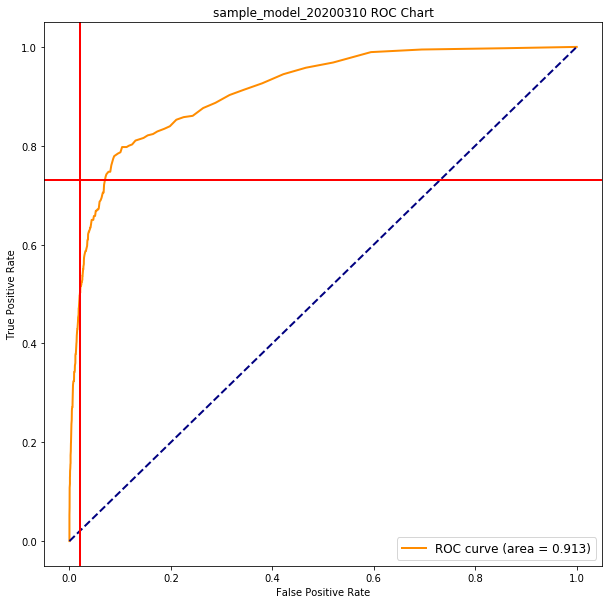

In [27]:
# -- model performance summary -- 
auc = fpr = eval(client.describe_model_versions(
    modelId= MODEL_NAME,
    modelVersionNumber='1.0',
    modelType='ONLINE_FRAUD_INSIGHTS',
    maxResults=10
)['modelVersionDetails'][0]['trainingMetrics']['auc'])

thr = eval(client.describe_model_versions(
    modelId= MODEL_NAME,
    modelVersionNumber='1.0',
    modelType='ONLINE_FRAUD_INSIGHTS',
    maxResults=10
)['modelVersionDetails'][0]['trainingMetrics']['thresholds'])


fpr = eval(client.describe_model_versions(
    modelId= MODEL_NAME,
    modelVersionNumber='1.0',
    modelType='ONLINE_FRAUD_INSIGHTS',
    maxResults=10
)['modelVersionDetails'][0]['trainingMetrics']['fpr'])

tpr = eval(client.describe_model_versions(
    modelId= MODEL_NAME,
    modelVersionNumber='1.0',
    modelType='ONLINE_FRAUD_INSIGHTS',
    maxResults=10
)['modelVersionDetails'][0]['trainingMetrics']['tpr'])

precision = eval(client.describe_model_versions(
    modelId= MODEL_NAME,
    modelVersionNumber='1.0',
    modelType='ONLINE_FRAUD_INSIGHTS',
    maxResults=10
)['modelVersionDetails'][0]['trainingMetrics']['precision'])
precision

df_model = pd.DataFrame(list(zip(thr, fpr, tpr, precision)), columns=['thr','fpr', 'tpr', 'precision'])


plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title( MODEL_NAME + ' ROC Chart')
plt.legend(loc="lower right",fontsize=12)
plt.axvline(x = 0.02 ,linewidth=2, color='r')
plt.axhline(y = 0.73 ,linewidth=2, color='r')
plt.show()

## Assemble the Detector  


-----
Creating a detector is a 5 part process: 

1. setup outcomes & rules 
2. create outcomes 
3. create rules 
4. create detector 
5. promote detector 

<div class="alert alert-info"> 💡 <strong> Authoring Rules </strong>

- Eyeball the sample rules for say 1%, 2%, 3% or 4% FPR 

- if in doubt note the threshold coresponding to 1% and use that in the next step

</div>

In [33]:
model_stat = df_model.round(decimals=2)               
m = model_stat.loc[model_stat.groupby(["fpr"])["thr"].idxmax()] 

def make_rule(x):
    return "\'$" + MODEL_NAME + "_insightscore > " + str(x) + "\'"
    
m['rule'] = m['thr'].apply(lambda x: make_rule(x))

print (" --- score thresholds 1% to 10% --- ")
print(m[["fpr", "tpr", "thr", "rule"]].loc[(m['fpr'] > 0.0 ) & (m['fpr'] <= 0.1)].reset_index(drop=True))


 --- score thresholds 1% to 10% --- 
    fpr   tpr    thr                                           rule
0  0.01  0.27  765.0  '$sample_model_20200310_insightscore > 765.0'
1  0.02  0.42  605.0  '$sample_model_20200310_insightscore > 605.0'
2  0.03  0.53  475.0  '$sample_model_20200310_insightscore > 475.0'
3  0.04  0.61  375.0  '$sample_model_20200310_insightscore > 375.0'
4  0.05  0.65  295.0  '$sample_model_20200310_insightscore > 295.0'
5  0.06  0.67  245.0  '$sample_model_20200310_insightscore > 245.0'
6  0.07  0.70  215.0  '$sample_model_20200310_insightscore > 215.0'
7  0.08  0.75  175.0  '$sample_model_20200310_insightscore > 175.0'
8  0.09  0.77  160.0  '$sample_model_20200310_insightscore > 160.0'
9  0.10  0.78  145.0  '$sample_model_20200310_insightscore > 145.0'


## Define Outcomes and Rules 
-----
the following dictionary contains both outcomes and sample rules 


<div class="alert alert-info"> 💡 <strong> Addiging & Editing Rules </strong>

- See the sample rules above, feel free to add an outcome and additional rules... in this case an outcome is mapped 1 to 1 with a rule but you can have an outcome map to as many rules as you'd like. 

<i>**Note: the _insightscores below are just place holders, you can add outcomes and "threshold" based rules as you like. just fit them into the OUTCOMES_AND_RULES dictionary.**</i>

</div>


```python
# -- Here i create a rule for each outcome, the outcome's description is the rule expression
OUTCOMES_AND_RULES = {
  "approve"     : f"${MODEL_NAME}_insightscore < 100",
  "investigate" : f"${MODEL_NAME}_insightscore >= 100 and ${MODEL_NAME}_insightscore < 200",
  "decline"     : f"${MODEL_NAME}_insightscore >= 200 and ${MODEL_NAME}_insightscore < 600",
  "alert"       : f"${MODEL_NAME}_insightscore >= 600",
}
```

In [34]:
# -- Here i create a rule for each outcome, the outcome's description is the rule expression
OUTCOMES_AND_RULES = {
  "approve"     : f"${MODEL_NAME}_insightscore < 475",
  "investigate" : f"${MODEL_NAME}_insightscore >= 475 and ${MODEL_NAME}_insightscore < 605",
  "decline"     : f"${MODEL_NAME}_insightscore >= 605 and ${MODEL_NAME}_insightscore < 765",
  "alert"       : f"${MODEL_NAME}_insightscore >= 765",
}

In [35]:
def create_outcomes(client, OUTCOMES_AND_RULES):
    """ create Fraud Detector Outcomes 
    
    """   
    for key, value in OUTCOMES_AND_RULES.items():
        print("creating outcome variable: " + key)
        response = client.put_outcome(
                          name=key,
                          description=value)
    
create_outcomes(client, OUTCOMES_AND_RULES)


creating outcome variable: approve
creating outcome variable: investigate
creating outcome variable: decline
creating outcome variable: alert


<div class="alert alert-info"> 💡 <strong>Create Rules </strong>

- This function creates a sample rule FOR EACH outcome in the OUTCOMES_AND_RULES dictionary above. 

</div>

In [36]:
def create_rules(client, OUTCOMES_AND_RULES):
    """ create rules for each outcome based on the outcome description 
    
    """
    rule_list = []
    
    for key in OUTCOMES_AND_RULES.keys():
        ruleId = key + "_" + MODEL_NAME + "_rule"
        detectorId = DETECTOR_NAME
        try:
            response = client.get_rules(
                    ruleId      = ruleId,
                    detectorId  = DETECTOR_NAME )
            vers = response['ruleDetails'][0]['ruleVersion']
            rule = {"ruleId" :ruleId,
                    "ruleVersion" : vers,
                    "detectorId" : detectorId}
            rule_list.append(rule)
            # print("Updating existing rule: "+ ruleId )
            
        except:
            # print("Creating rule: " +  ruleId )
            response = client.create_rule(
                    ruleId      = ruleId,
                    detectorId  = DETECTOR_NAME,
                    description = OUTCOMES_AND_RULES[key],
                    expression  = OUTCOMES_AND_RULES[key],
                    language    ='DETECTORPL',
                    outcomes    =[key])
            vers = '1.0'
            rule = {"ruleId" :ruleId,
                    "ruleVersion" : vers,
                    "detectorId" : detectorId}
            
            rule_list.append(rule)
    return rule_list 
            

rule_list = create_rules(client, OUTCOMES_AND_RULES)
print("\n -- rule list --")
print(rule_list)


 -- rule list --
[{'ruleId': 'approve_sample_model_20200310_rule', 'ruleVersion': '1.0', 'detectorId': 'sample_detector_20200310'}, {'ruleId': 'investigate_sample_model_20200310_rule', 'ruleVersion': '1.0', 'detectorId': 'sample_detector_20200310'}, {'ruleId': 'decline_sample_model_20200310_rule', 'ruleVersion': '1.0', 'detectorId': 'sample_detector_20200310'}, {'ruleId': 'alert_sample_model_20200310_rule', 'ruleVersion': '1.0', 'detectorId': 'sample_detector_20200310'}]


### Create Detector 
----
Finally, we can create the detector. It is a two part process 
1. create the detector Version
2. activate the detection (change the status to ACTIVE)

<div class="alert alert-info"> 💡 <strong> Detectors </strong>

- PUT - creates an empty detector 
- CREATE Version - assembles the detector, model(s) and rules(s), 
- UPDATE - changes the status from DRAFT to ACTIVE 

</div>

In [37]:
response = client.create_detector_version(
    detectorId  = DETECTOR_NAME,
    description = DETECTOR_DESC,
    modelVersions = [{"modelId":MODEL_NAME, 
                     "modelType" : "ONLINE_FRAUD_INSIGHTS",
                     "modelVersionNumber" : "1.0"}],
    rules = rule_list
)
print("\n -- detector created -- ")
print(response) 


 -- detector created -- 
{'detectorId': 'sample_detector_20200310', 'detectorVersionId': '2.0', 'status': 'DRAFT', 'ResponseMetadata': {'RequestId': '0b3aae02-35ba-417e-a320-d9bc55f01e11', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Tue, 10 Mar 2020 18:58:32 GMT', 'x-amzn-requestid': '0b3aae02-35ba-417e-a320-d9bc55f01e11', 'content-length': '84', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


In [38]:
response = client.update_detector_version_status(
    detectorId= DETECTOR_NAME,
    detectorVersionId='1.0',
    status='ACTIVE'
)
print("\n -- detector activated -- ")
print(response)


 -- detector activated -- 
{'ResponseMetadata': {'RequestId': '7721f02a-3967-48ff-8e9e-4a80d48a1c6c', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Tue, 10 Mar 2020 18:58:42 GMT', 'x-amzn-requestid': '7721f02a-3967-48ff-8e9e-4a80d48a1c6c', 'content-length': '2', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


### Evaluate Your Detector 
-----

- pass a single record to your Detector
- pass a set of records to your Detector 


<div class="alert alert-info"> 💡 <strong> Infrencing, Scoring & Decision-ing </strong>

Now you have a detector that is comprised of a model that produces a score and rules that produce outcomes.  

In realtime AWS' Fraud Detector will perform the following durring infrence:
- deal with missing values 
- enrich your data 
- transform you data 
- apply 0 - N models 
- apply 1 - N rules 
- return a result 

</div>


In [39]:
def get_model_variables(MODEL_NAME):
    """ return list of variables used by a model 
    
    """
    response = client.get_models(
    modelType='ONLINE_FRAUD_INSIGHTS',
    modelId= MODEL_NAME)
    model_variables = []

    for v in response['models'][0]['modelVariables']:
        model_variables.append(v['name'])
    return model_variables

model_variables = get_model_variables(MODEL_NAME)
print("\n -- model variables -- ")
print(model_variables)


 -- model variables -- 
['order_amt', 'ip_address', 'email_address', 'credit_card_bin', 'billing_postal', 'shipping_postal', 'event_timestamp']


In [40]:
# -- predict on a single record  
pred_data = df[model_variables].head(1).astype(str).to_dict(orient='records')

for rec in pred_data:
    stime = time.time()
    pred = client.get_prediction(detectorId=DETECTOR_NAME, detectorVersionId='1.0', eventId='1', eventAttributes=rec)         
    etime = time.time()
    print(str(pred['modelScores'][0]['scores'][MODEL_NAME + '_insightscore']) + " - score in = %s" % round((etime - stime)*1000,2) + " ms")
    print("\n",pred)


50.0 - score in = 169.54 ms

 {'outcomes': ['approve'], 'modelScores': [{'modelVersion': {'modelId': 'sample_model_20200310', 'modelType': 'ONLINE_FRAUD_INSIGHTS', 'modelVersionNumber': '1.0'}, 'scores': {'sample_model_20200310_insightscore': 50.0}}], 'ResponseMetadata': {'RequestId': 'ce319ea0-71e2-487c-873b-aaff148dffef', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Tue, 10 Mar 2020 18:58:52 GMT', 'x-amzn-requestid': 'ce319ea0-71e2-487c-873b-aaff148dffef', 'content-length': '209', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


### Predict on a Set of Records 

<div class="alert alert-info"> 💡 <strong> Evaluate </strong>

-  Change **record_count** to the number of rectods you want to predict  

</div>

#### Alternatively, if you want to predict on a different dataset

- Simply create a new data frame to score on. 

```python

# -- in this case the prediction dataframe is called "df" 

df = pd.read_csv(new-dataset-to-predict-on.csv)


```

In [41]:
# -- to predict on a subset of records simply change record count 
record_count = 500

pred_data = df[model_variables].head(record_count).astype(str).to_dict(orient='records')
dat = []
i=0
for rec in pred_data:
    # print(rec)
    clear_output(wait=True)
    stime = time.time()
    pred = client.get_prediction(detectorId=DETECTOR_NAME, detectorVersionId='1.0', eventId=str(i), eventAttributes=rec)         
    etime = time.time()
    rec['score'] = pred['modelScores'][0]['scores'][MODEL_NAME + '_insightscore']
    rec['score_ms'] = ((etime - stime)*1000)
    rec['rule_outcome'] = ['outcomes'][0]
    dat.append(rec)
    i += 1 
    print("current progress: ", round((i/record_count)*100,2), "%" )
 
    

current progress:  100.0 %


#### Eyeball a sample of predictions 
-----


In [46]:
# -- Review sample of predictions 
predictions = pd.DataFrame.from_dict(dat, orient='columns')
predictions.head()

,billing_postal,credit_card_bin,email_address,event_timestamp,ip_address,order_amt,rule_outcome,score,score_ms,shipping_postal
0,17740-2745,42785,synth_patrickjennings@gmail.com,2019-03-31 11:21:22,192.18.59.93,8036.0,outcomes,50.0,174.194813,20950-6945
1,81975-4358,30004,synth_nicholas60@yahoo.com,2019-06-23 02:13:27,192.88.102.55,7839.0,outcomes,83.0,158.268213,10975-4292
2,96275-0682,54517,synth_chill@yahoo.com,2019-04-13 23:55:51,192.52.207.254,3225.0,outcomes,66.0,212.044477,89722-4734
3,49934-1837,35933,synth_ericksonrandy@yahoo.com,2020-01-03 18:29:06,198.10.49.139,8109.0,outcomes,77.0,123.425484,31347-4011
4,88645-7360,54658,synth_gwade@hotmail.com,2019-08-16 07:03:38,192.0.116.87,4926.0,outcomes,18.0,299.652100,03075-4962


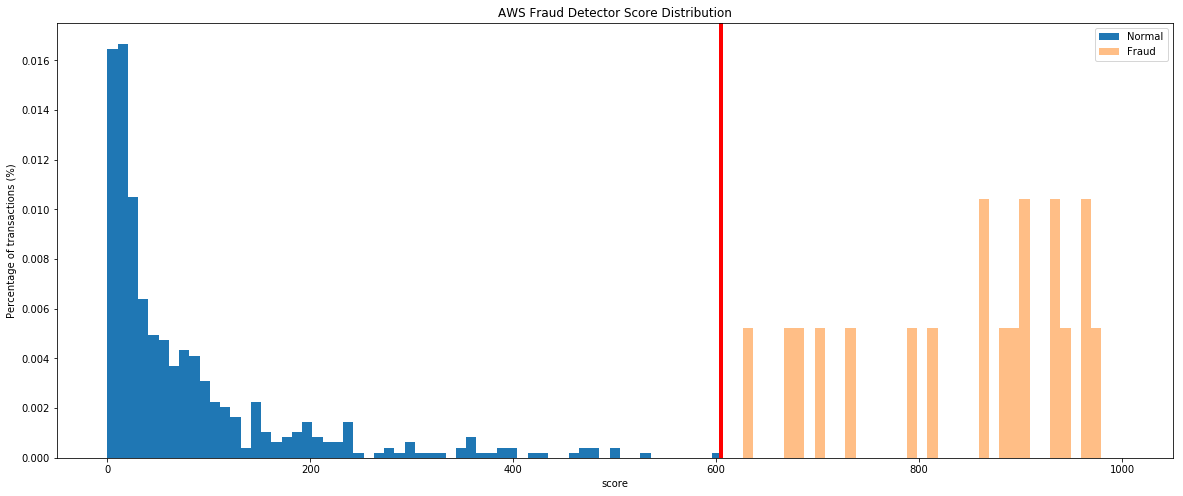

In [51]:
# -- example threshold might be at the 2% FPR rate 
score_threshold = 605.0
# -- assign predictions based on threshold --
predictions.loc[predictions['score'].astype(float) > score_threshold, "predicted_fraud" ] = 1
predictions.loc[predictions['score'].astype(float) <= score_threshold, "predicted_fraud" ] = 0


fraud = predictions.loc[predictions["predicted_fraud"] == 1 ]
legit = predictions.loc[predictions["predicted_fraud"] == 0 ]

bins = np.linspace(0, 1000, 100)
plt.figure(figsize=(20,8))
plt.hist(legit['score'].astype(float) , bins, alpha=1, density=True, label='Normal')
plt.hist(fraud['score'].astype(float) , bins, alpha=0.5, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("AWS Fraud Detector Score Distribution")
plt.xlabel("score")
plt.ylabel("Percentage of transactions (%)");
plt.axvline(x = score_threshold ,linewidth=4, color='r')
plt.show()

### Optionally Write Predictions to File

<div class="alert alert-info"> <strong> Write Predictions </strong>

- You can write your prediction dataset to a CSV to manually review predictions
- Simply add a cell below and copy the code below

</div>



```python

# -- optionally write predictions to a CSV file -- 
predictions.to_csv(MODEL_NAME + ".csv", index=False)
# -- or to a XLS file 
predictions.to_excel(MODEL_NAME + ".xlsx", index=False)

```